# Chapter 2: Case Study
## March 24-27, 2023 Tornado Outbreak

```{image} ../thumbnails/thumbnail.png
:alt: Project Pythia logo
:width: 200px
```

Next, title your notebook appropriately with a top-level Markdown header, `#` (see the very first cell above). Do not use this level header anywhere else in the notebook. Our book build process will use this title in the navbar, table of contents, etc. Keep it short, keep it descriptive. 

Follow this with a `---` cell to visually distinguish the transition to the prerequisites section.

---

## Overview
The tornado outbreak of March 24–27, 2023 was a devastating multi-day severe weather event that swept across the Southern United States, particularly impacting Mississippi, Alabama, Tennessee, and Georgia. Triggered by a slow-moving upper-level trough interacting with moist, unstable air from the Gulf of Mexico, the outbreak produced 35 confirmed tornadoes, including a violent EF4 that tore through Rolling Fork, Midnight, and Silver City, Mississippi with peak winds of 195 mph. That tornado alone caused catastrophic damage and multiple fatalities, prompting tornado emergencies and widespread destruction.
Over the four-day span, the system also unleashed damaging straight-line winds, large hail, and flooding. In total, the outbreak resulted in 23 fatalities (plus two from non-tornadic causes), over 230 injuries, and an estimated $1.9 billion in damage. The event was notable not only for its intensity but also for its geographic breadth and the prolonged nature of the severe weather threat.

--- 
This chapter explores MRMS data from this tornado outbreak, using: 
 - Reflectivity
 - Rotation
 - Hail Swaths
 - Local Storm Reports

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

In [1]:
import sys
import s3fs
import urllib
import tempfile
import gzip
import xarray as xr
import xarray
import io
import numpy as np
import cartopy
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def fetch_mrms_data(variable: str, yyyymmdd: str, hh: str) -> xr.DataArray:
    """
    Downloads and loads MRMS data from NOAA PDS.

    Parameters:
        variable (str): MRMS product name (e.g., 'MergedReflectivityQC').
        yyyymmdd (str): Date in YYYYMMDD format.
        hh (str): Hour in HH format (00–23 UTC).

    Returns:
        xarray.DataArray: Decoded MRMS data array.
    """
    url = (
        f"https://noaa-mrms-pds.s3.amazonaws.com/CONUS/{variable}/"
        f"{yyyymmdd}/MRMS_{variable}_{yyyymmdd}-{hh}0000.grib2.gz"
    )

    response = urllib.request.urlopen(url)
    compressed_file = response.read()

    with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
        f.write(gzip.decompress(compressed_file))
        data_in = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

    return data_in

In [3]:
# response = urllib.request.urlopen("https://noaa-mrms-pds.s3.amazonaws.com/CONUS/CREF_1HR_MAX_00.50/20230325/MRMS_CREF_1HR_MAX_00.50_20230325-010000.grib2.gz")

# compressed_file = response.read()

# with tempfile.NamedTemporaryFile(suffix=".grib2") as f:
#             f.write(gzip.decompress(compressed_file))
#             data_in = xr.load_dataarray(f.name, engine='cfgrib', decode_timedelta=True)

##  Composite Reflectivity

### Let's bring in some data to work with! 

In [5]:
#### March 24, 2023 - Rolling Fork - Silver City, MS Tornado -- EF4, 71 minutes long, est winds 195 mph
## 3/25/23 1z to 2z, so we'll grab two hours of data shortly

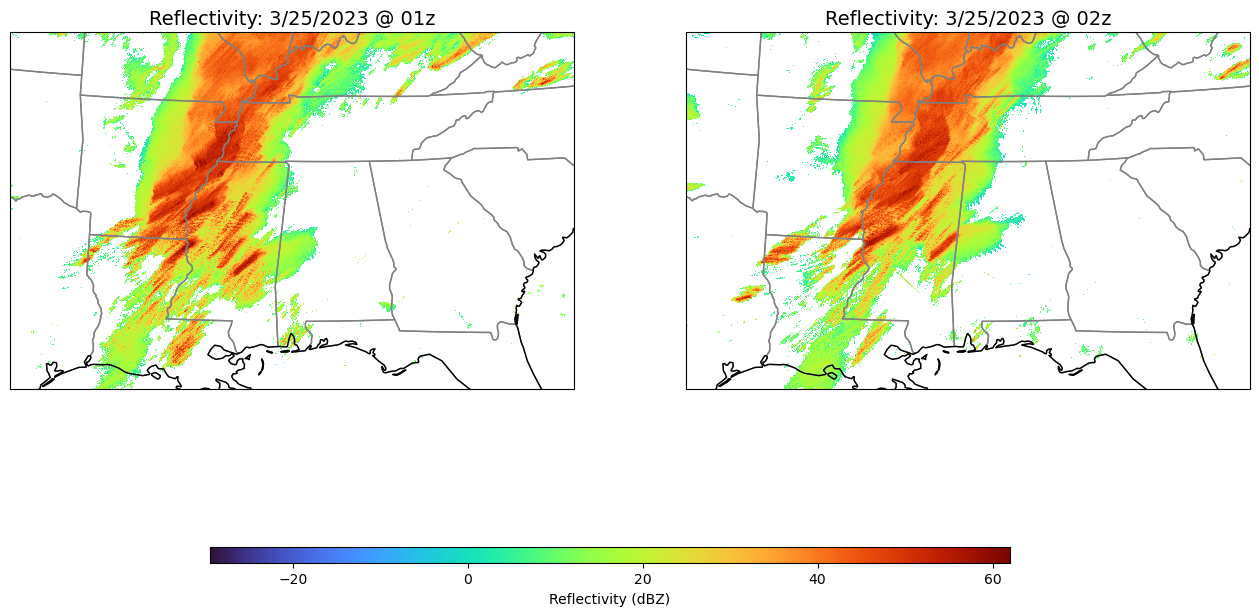

In [8]:
cref1z = fetch_mrms_data('CREF_1HR_MAX_00.50', '20230325', '01')
cref2z = fetch_mrms_data('CREF_1HR_MAX_00.50', '20230325', '02')

# Define bounds for Dixie Alley
lon_min, lon_max = -96, -80
lat_min, lat_max = 29, 38
projection = ccrs.LambertConformal(central_longitude=-88, central_latitude=34)

# Mask fill values for both datasets
masked1 = np.ma.masked_where(cref1z == -99.0, cref1z)
masked2 = np.ma.masked_where(cref2z == -99.0, cref2z)

# Create side-by-side subplots
fig, axes = plt.subplots(
    1, 2, figsize=(16, 8),
    subplot_kw={'projection': projection},
    gridspec_kw={'bottom': 0.2}  # leave room for shared colorbar
)

meshes = []
for ax, masked, title in zip(axes, [masked1, masked2], ["Reflectivity: 3/25/2023 @ 01z", "Reflectivity: 3/25/2023 @ 02z"]):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle='--', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    
    mesh = ax.pcolormesh(
        cref2z.longitude, cref2z.latitude, masked,
        cmap='turbo', transform=ccrs.PlateCarree(), shading='auto'
    )
    ax.set_title(title, fontsize=14)
    meshes.append(mesh)

# Add shared colorbar beneath both plots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(meshes[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Reflectivity (dBZ)')

# plt.tight_layout()
plt.show()

## Surface Precip Rate
### Every 2 minutes! To show a difference, here is an hour.

In [4]:
precip_1z = fetch_mrms_data('PrecipRate_00.00', '20230325', '01') # Precip Rate
precip_2z = fetch_mrms_data('PrecipRate_00.00', '20230325', '02')
masked1 = np.ma.masked_where(precip_1z == 0, precip_1z)
masked2 = np.ma.masked_where(precip_2z == 0, precip_2z)

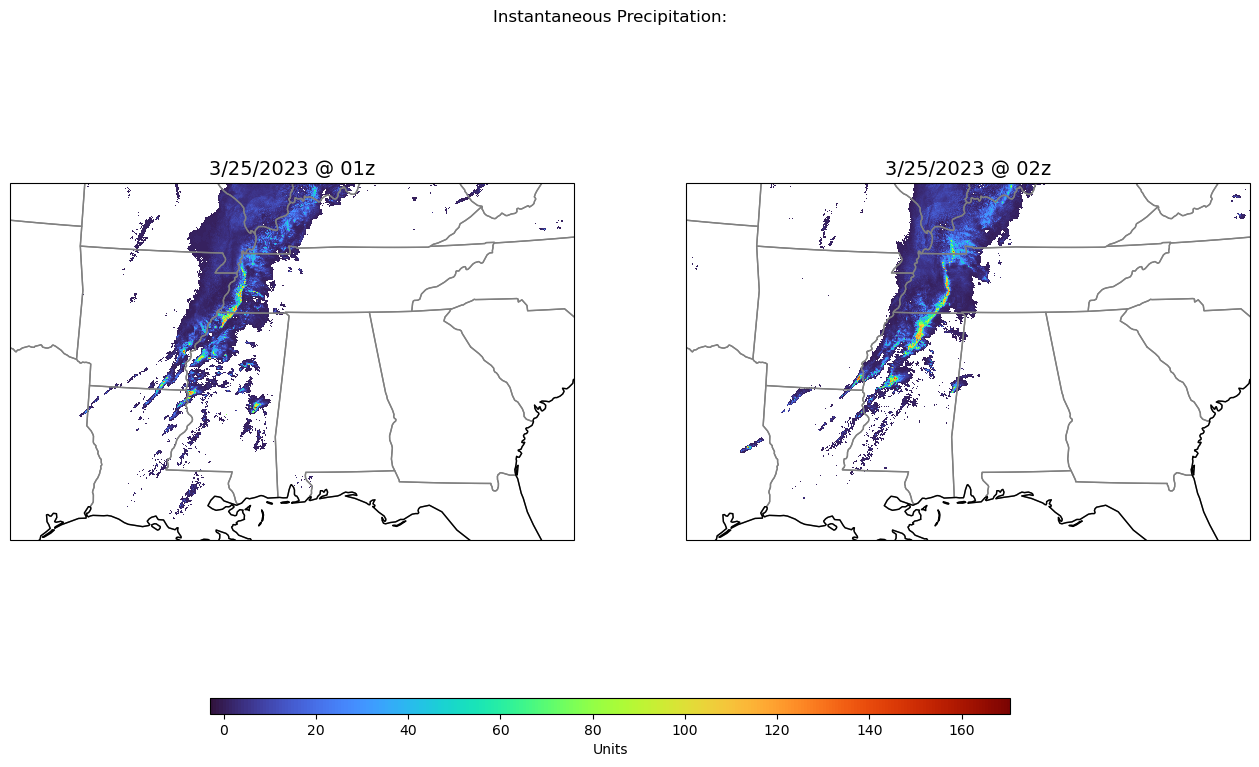

In [5]:
# Define bounds for Dixie Alley
lon_min, lon_max = -96, -80
lat_min, lat_max = 29, 38
projection = ccrs.LambertConformal(central_longitude=-88, central_latitude=34)

# Create side-by-side subplots
fig, axes = plt.subplots(
    1, 2, figsize=(16, 8),
    subplot_kw={'projection': projection},
    gridspec_kw={'bottom': 0.2}  # leave room for shared colorbar
)

meshes = []
for ax, masked, title in zip(axes, [masked1, masked2], ["3/25/2023 @ 01z", "3/25/2023 @ 02z"]):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle='--', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    
    mesh = ax.pcolormesh(
        precip_1z.longitude, precip_1z.latitude, masked,
        cmap='turbo', transform=ccrs.PlateCarree(), shading='auto'
    )
    ax.set_title(title, fontsize=14)
    meshes.append(mesh)

# Add shared colorbar beneath both plots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(meshes[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Units')
plt.suptitle('Instantaneous Precipitation:')

# plt.tight_layout()
plt.show()

In [6]:
# MultiSensor_QPE_01H_Pass1_00.00
QPE_1z = fetch_mrms_data('MultiSensor_QPE_01H_Pass1_00.00', '20230325', '01') # QPE: Quantified Precip Estimation - Offered hourly.
QPE_2z = fetch_mrms_data('MultiSensor_QPE_01H_Pass1_00.00', '20230325', '02') 


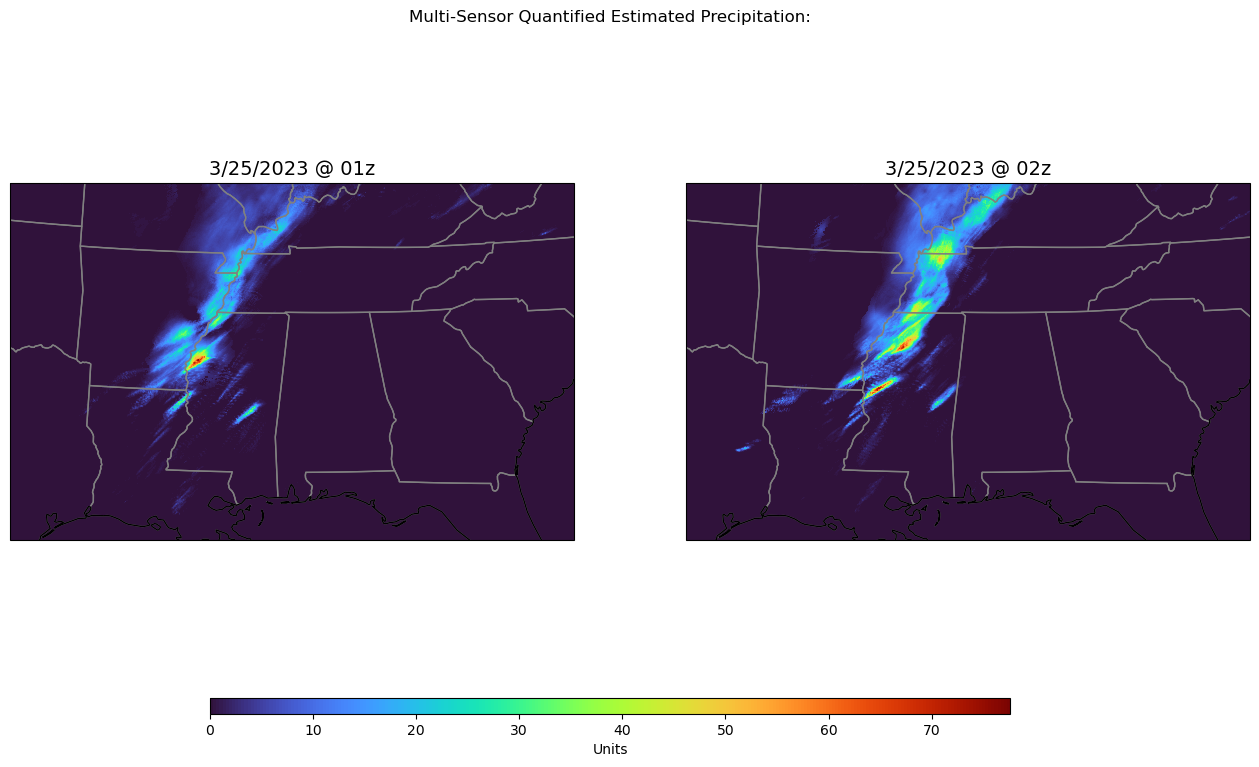

In [8]:
# Define bounds for Dixie Alley
lon_min, lon_max = -96, -80
lat_min, lat_max = 29, 38
projection = ccrs.LambertConformal(central_longitude=-88, central_latitude=34)

# Create side-by-side subplots
fig, axes = plt.subplots(
    1, 2, figsize=(16, 8),
    subplot_kw={'projection': projection},
    gridspec_kw={'bottom': 0.2}  # leave room for shared colorbar
)

meshes = []
for ax, masked, title in zip(axes, [QPE_1z, QPE_2z], ["3/25/2023 @ 01z", "3/25/2023 @ 02z"]):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='gray')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle='--', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    
    mesh = ax.pcolormesh(
        QPE_1z.longitude, QPE_1z.latitude, masked,
        cmap='turbo', transform=ccrs.PlateCarree(), shading='auto'
    )
    ax.set_title(title, fontsize=14)
    meshes.append(mesh)

# Add shared colorbar beneath both plots
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(meshes[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Units')
plt.suptitle('Multi-Sensor Quantified Estimated Precipitation:')

# plt.tight_layout()
plt.show()

In [ ]:
# RadarOnly_QPE_01H_00.00

## Rotation

In [ ]:
# MergedAzShear_0-2kmAGL_00.50
# MergedAzShear_3-6kmAGL_00.50

In [ ]:
# RotationTrack30min_00.50
# RotationTrack60min_00.50
# RotationTrackML60min_00.50
# RotationTrackML30min_00.50

## Hail Swaths

In [ ]:
# MESH - Maximum Expected Size of Hail
# SHI_00.50 - Severe Hail Index
# VII_00.50 - Vergically Integrated Ice
# POSH_00.50

## Storm Intensity - Vertically Integrated Liquid

In [ ]:
# VIL_00.50		
# VIL_Density_00.50			
# VIL_Max_120min_00.50

### A content subsection
Divide and conquer your objectives with Markdown subsections, which will populate the helpful navbar in Jupyter Lab and here on the Jupyter Book!

In [ ]:
# some subsection code
a = [1, 2, 3, 4, 5]
[i + 2 for i in a]

### Another content subsection
Keep up the good work! A note, *try to avoid using code comments as narrative*, and instead let them only exist as brief clarifications where necessary.

## Your second content section
Here we can move on to our second objective, and we can demonstrate...

### A subsection to the second section

#### a quick demonstration

##### of further and further

###### header levels

as well as $m = a * t / h$ text! Similarly, you have access to other $\LaTeX$ equation [**functionality**](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html) via MathJax:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

Check out [**any number of helpful Markdown resources**](https://www.markdownguide.org/basic-syntax/) for further customizing your notebooks and the [**MyST Syntax Overview**](https://mystmd.org/guide/syntax-overview) for MyST-specific formatting information. Don't hesitate to ask questions if you have problems getting it to look *just right*.

## Last Section

You can add [admonitions using MyST syntax](https://mystmd.org/guide/admonitions):

:::{note}
Your relevant information here!
:::

Some other admonitions you can put in ([there are 10 total](https://mystmd.org/guide/admonitions#admonitions-list)):

:::{hint}
A helpful hint.
:::

:::{warning}
Be careful!
:::

:::{danger}
Scary stuff be here.
:::

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!